# Recommendations with IBM

In this notebook, we will be using real data from the IBM Watson Studio platform to create recommendations.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

# Read in data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# How much data do we have in df?
print ('There are {} rows and {} columns in df'.format(df.shape[0], df.shape[1]) )

There are 45993 rows and 3 columns in df


The three columns contain the `article_id`, the `title` of the article 
and the `email` hash of the user that has accessed that article. 

Thus, each row in `df` is an article-user interaction.

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
print ('There are {} rows and {} columns in df_content'.format(df_content.shape[0], df_content.shape[1]) )

There are 1056 rows and 5 columns in df_content


Each row in `df_content` contains information about a single article.

The most important columns to note here are the `article_id` and the `doc_full_name` of the article. 

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

**`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.**  

The `email` column of the `df` DataFrame is a proxy for the user_id (assuming each user only has one email).

By grouping the `df` column by email, we can determine how many article each user interacts with.

In [5]:
users_interactions_count = pd.DataFrame(df.groupby('email').size()).reset_index()
users_interactions_count = users_interactions_count.rename(columns = {"email": "user email", 0 : "Number of interactions"})
users_interactions_count = users_interactions_count.sort_values(by = "Number of interactions", ascending = False)
users_interactions_count.head()

,user email,Number of interactions
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


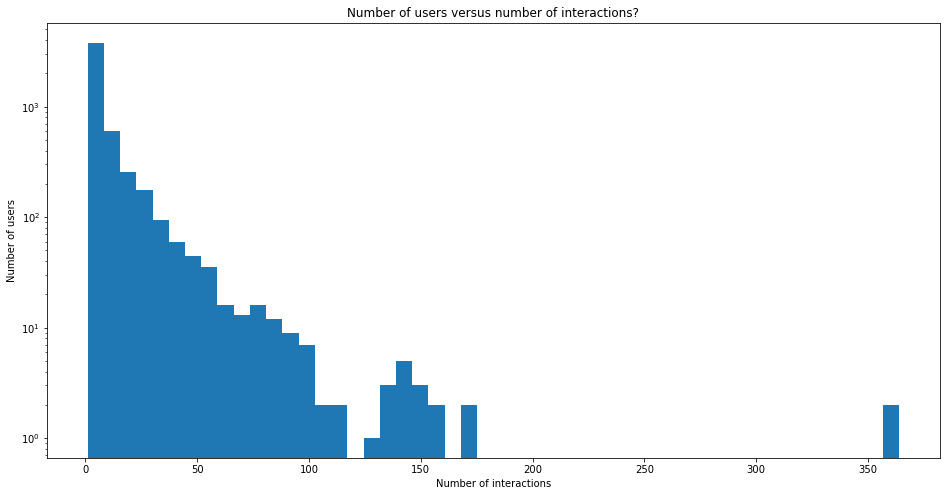

In [6]:
# Visualise
plt.figure(figsize=(16,8))
plt.hist(users_interactions_count["Number of interactions"], bins = 50);
#plt.xticks(np.arange(0,370,10))
plt.xlabel("Number of interactions");
plt.ylabel('Number of users');
plt.semilogy()
plt.title('Number of users versus number of interactions?');

We see in the log graph above an asymmetrical distribution, with most users interacting with less than 10 articles. There is a small group of outliers who have interacted with more than 350 articles. 

In [7]:
# The median and maximum number of user_article interactions:
median_val = users_interactions_count["Number of interactions"].median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = users_interactions_count["Number of interactions"].max() # The maximum number of user-article interactions by any 1 user is ______.

In [8]:
print("50% of individuals interact with {} articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


**`2.` Explore and remove duplicate articles from the **df_content** dataframe.**  

In [9]:
# Find and explore duplicate articles
print( "The number of exactly duplicated rows is:", sum(df_content.duplicated()) )
print("The number of rows that have a duplicated article_id is:", sum(df_content['article_id'].duplicated()) )

The number of exactly duplicated rows is: 0
The number of rows that have a duplicated article_id is: 5


Let us check which these are...

In [10]:
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


 Let us double-check that these really are duplicates by checking the first article_id (50)

In [11]:
df_content[df_content['article_id'] == 50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


We have confirmed that there are two articles with the same article id that differ in the doc_description.

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content[~df_content['article_id'].duplicated()]
# Check that the duplicates are removed.
print( "The number of rows that have a duplicated article_id is now:", sum(df_content['article_id'].duplicated()) )

The number of rows that have a duplicated article_id is now: 0


`3.` 

**Use the cells below to find:**

**a. The number of unique articles that have an interaction with a user.  
b. The number of unique articles in the dataset (whether they have any interactions or not).<br>
c. The number of unique users in the dataset. (excluding null values) <br>
d. The number of user-article interactions in the dataset.**

In [13]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
unique_articles

714

In [14]:
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform
total_articles

1051

In [15]:
unique_users = df['email'].nunique() # The number of unique users (this function excludes nulls)
unique_users

5148

In [16]:
user_article_interactions = df.shape[0] # The number of user-article interactions
user_article_interactions

45993

**`4.` Use the cells below to find the most viewed `article_id`, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).**

By grouping the `df` column by article_id, we can determine how many interactions each article has.

In [17]:
article_interactions_count = pd.DataFrame(df.groupby('article_id').size()).reset_index()
article_interactions_count = article_interactions_count.rename(columns = {0 : "Number of interactions"})
article_interactions_count = article_interactions_count.sort_values(by = "Number of interactions", ascending = False)
article_interactions_count.head()

,article_id,Number of interactions
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [18]:
most_viewed_article_id = str(article_interactions_count.iloc[0,0])
most_viewed_article_id # The most viewed article in the dataset as a string with one value following the decimal

'1429.0'

In [19]:
max_views = article_interactions_count.iloc[0,1]
max_views # The most viewed article in the dataset was viewed how many times?

937

In [20]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
print     ('`50% of individuals have {} or fewer interactions.`'.format(median_val) )
print     ('`The total number of user-article interactions in the dataset is {}.`'.format(user_article_interactions) )
print     ('`The maximum number of user-article interactions by any 1 user is {}.`'.format(max_views_by_user) )
print     ('`The most viewed article in the dataset was viewed {} times.`'.format(max_views) )
print     ('`The article_id of the most viewed article is {}.`'.format(most_viewed_article_id) )
print     ('`The number of unique articles that have at least 1 rating {}.`'.format(unique_articles) )
print     ('`The number of unique users in the dataset is {}`'.format(unique_users) )
print     ('`The number of unique articles on the IBM platform is {}`'.format(total_articles) )

`50% of individuals have 3.0 or fewer interactions.`
`The total number of user-article interactions in the dataset is 45993.`
`The maximum number of user-article interactions by any 1 user is 364.`
`The most viewed article in the dataset was viewed 937 times.`
`The article_id of the most viewed article is 1429.0.`
`The number of unique articles that have at least 1 rating 714.`
`The number of unique users in the dataset is 5148`
`The number of unique articles on the IBM platform is 1051`


In [22]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [23]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_interactions_count = pd.DataFrame(df.groupby('article_id').size()).reset_index()
    article_interactions_count = article_interactions_count.rename(columns = {0 : "Number of interactions"})
    article_interactions_count = article_interactions_count.sort_values(by = "Number of interactions", ascending = False)
    top_articles = (article_interactions_count.iloc[0:n].article_id.values).tolist()

    return top_articles # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_singular = df[~df['article_id'].duplicated()] # Ignore any duplicated article_ids
    article_ids = get_top_article_ids(n, df=df)
    top_articles = []
    for an_id in article_ids:
        top_articles.append(df_singular[df_singular['article_id']== an_id].title.values[0])
    return top_articles # Return the top article titles from df (not df_content)

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_simple = df[['article_id', 'user_id']]
    df_simple['interactions'] = 1
    user_item = df_simple.groupby(['user_id', 'article_id'])['interactions'].max().unstack()
    user_item.fillna(0, inplace = True) # Ensure that any na values are zero
     
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [27]:
# Perform a quick visual inspection
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    user_row = (user_item.loc[user_id, :]).to_numpy()      
    closeness = []
    for index, row in user_item.iterrows(): # Index through every user row
        other_user_column = row.to_numpy().transpose()
        closeness.append(np.dot(user_row, other_user_column)) 
    closeness = np.array(closeness)
    
    # create list of just the ids & sort by similarity
    ids =  closeness.argsort()[::-1]
    closeness = closeness[ids]
    ids = ids + 1 # to correct for the zero based indexing
    
    # remove the own user's id
    similar_users = np.delete(ids, np.where(ids == user_id))
          
    return similar_users # return a list of the users in order from most to least similar

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    df_singular = df[~df['article_id'].duplicated()] # Ignore any duplicated article_ids
    article_ids  = [float(an_id) for an_id in article_ids]
    article_names = list(df_singular[ df_singular['article_id'].isin(article_ids) ].title.values)
    
    return article_names # Return the article names associated with list of article ids



def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Identify the correct row in the user_item matrix
    user_row = user_item.iloc[int(user_id)-1:int(user_id)] # The -1 corrects for zero-based indexing
   
    # Remove columns with zeros (these are articles the user **has not** interacted with)
    user_row = user_row.loc[:, (user_row != 0).any(axis=0)] # https://stackoverflow.com/questions/21164910/how-do-i-delete-a-column-that-contains-only-zeros-in-pandas
    
    # The names of the remaining columns are the article_ids the user **has** interacted with.
    article_ids = user_row.columns.astype(str).to_list()
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    **Users who are the same closeness are chosen arbitrarily as the 'next' user**
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    article_ids_already_seen = get_user_articles(user_id=user_id, user_item=user_item)[0] 
    recs = []
    
    for a_user in similar_users:
        article_ids, article_names = get_user_articles(user_id=a_user, user_item=user_item)
        new_records = np.setdiff1d(article_ids, article_ids_already_seen) # Keep only unseen article_ids
        recs.extend( np.setdiff1d(new_records, recs) ) # Add any newly found recommendations
        if len(recs) >= m: break
            
    return recs[0:m] # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def find_similar_users_df(user_id, user_item=user_item):
    '''
    This function is the essentially the same as the first, except that it returns a dataframe.
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    user_row = (user_item.loc[user_id, :]).to_numpy()      
    closeness = []
    for index, row in user_item.iterrows(): # Index through every user row
        other_user_column = row.to_numpy().transpose()
        closeness.append(np.dot(user_row, other_user_column)) 
    closeness = np.array(closeness)
    
    # create list of just the ids & sort by similarity
    ids =  closeness.argsort()[::-1]
    closeness = closeness[ids]
    ids = ids + 1 # to correct for the zero based indexing
    
    # remove the own user's id
    similar_users = np.delete(ids, np.where(ids == user_id))
    closeness = closeness[1:]
    
    # make a dataframe
    similar_users_df = pd.DataFrame([similar_users,closeness]).transpose()
    similar_users_df.columns = ['neighbor_id', 'similarity']
    return similar_users_df # return a list of the users in order from most to least similar

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Create a dataframe that contains the similarity of each user to the provided user_id
    similarity = find_similar_users_df(user_id=int(user_id), user_item=user_item)
    
    # Create a dataframe that contains the the number of articles viewed by the user    
    num_interactions_count = pd.DataFrame(df.groupby('user_id').size()).reset_index()
    num_interactions_count.columns = ['neighbor_id', 'num_interactions'] 
    num_interactions_count = num_interactions_count[~(num_interactions_count.neighbor_id == user_id)]
    num_interactions_count = num_interactions_count.sort_values(by = "num_interactions", ascending = False)
    
    neighbors_df = pd.merge(similarity, num_interactions_count, on = 'neighbor_id')
    neighbors_df = neighbors_df.sort_values(by = ["similarity", "num_interactions"], ascending = False)
    
    return neighbors_df.reset_index(drop = True) 

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    similar_users = get_top_sorted_users(user_id, df=df, user_item=user_item).neighbor_id.values
    article_ids_already_seen = get_user_articles(user_id=user_id, user_item=user_item)[0]

    recs = []
    
    for a_user in similar_users:
        article_ids, article_names = (get_user_articles(user_id=a_user, user_item=user_item))
        articles_unseen = list(set(article_ids) - set(article_ids_already_seen))
        recs =  set( list(recs) + articles_unseen) 
        if len(recs) >= m: break
    recs = list(recs)[0:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1304.0', '465.0', '1357.0', '1424.0', '1331.0', '12.0', '1153.0', '205.0', '793.0', '981.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'gosales transactions for logistic regression model', 'intentional homicide, number and rate per 100,000 population, by country', "a beginner's guide to variational methods", 'super fast string matching in python', '10 powerful features on watson data platform, no coding necessary', 'use spark for python to load data and run sql queries', 'introduction to neural networks, advantages and applications', 'airbnb data for analytics: vienna calendar', 'overlapping co-cluster recommendation algorithm (ocular)']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df, user_item).loc[0]['neighbor_id']
print(user1_most_sim)

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df, user_item).loc[9]['neighbor_id']
print(user131_10th_sim)

3933.0
242.0


In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**We can use get_top_article_ids() along with get_top_articles() to simply recommend the most popular articles. 
A better method would be to categorize the articles according to subject matter, ask the user which subjects interest them and filter popular articles according to subject matter.**

**Alternatively, instead of asking the user, we can wait to provide recommendations until the user has interacted with some articles.** 


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)
new_user_recs = [str(rec) for rec in new_user_recs] # article_ids need to be strings

In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [40]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [41]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Check the shape
user_item_matrix.shape

(5149, 714)

In [43]:
# Are there any null values?
user_item_matrix.isnull().values.any()

False

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [44]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [45]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**We have previously discovered that performing SVD is not possible if there are any null values in the matrix. Since, our matrix contains no null values (because no interaction is represent as 0), SVD can be performed.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

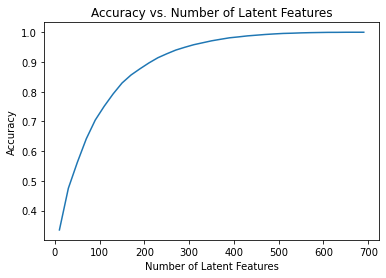

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    This function uses the user_item_matrix we have loaded from a file.
    
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Note: if we did not want to load from a file, we could use our create_user_item_matrix(df) function,
    e.g., 
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    '''
    
    user_item_train = user_item_matrix.iloc[ user_item_matrix.index.isin(list(set(df_train.user_id))) ] #correct rows
    correct_columns =  [str(article_id) for article_id in (list(set(df_train.article_id)))]
    user_item_train = user_item_train[correct_columns]

    user_item_test = user_item_matrix.iloc[ user_item_matrix.index.isin(list(set(df_test.user_id))) ] #correct rows
    correct_columns =  [str(article_id) for article_id in (list(set(df_test.article_id)))]
    user_item_test = user_item_test[correct_columns]
    
    test_idx =  [idx for idx in user_item_test.index]
    test_arts = [idx for idx in user_item_test.columns]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
# A quick look at the numbers
print(user_item_matrix.shape)
print(len(set(test_idx)))
print(len(test_arts))
print(user_item_train.shape)
print(user_item_test.shape)

(5149, 714)
682
574
(4487, 714)
(682, 574)


To predict, there must be commonality (of article_ids and or user_ids) between test and training data.

In [49]:
predictions = set(test_idx).intersection(user_item_train.index)
print('How many users can we make predictions for in the test set?')
print(len(predictions)) # We can predict 20 users
# print( user_item_train.index.intersection(user_item_test.index) ) #prints the user_ids of the users that can be predicted

print("How many users in the test set are we not able to make predictions for because of the cold start problem?")
print(user_item_test.shape[0] - len(predictions)) # We cannot predict 662 users

How many users can we make predictions for in the test set?
20
How many users in the test set are we not able to make predictions for because of the cold start problem?
662


In [50]:
print('How many articles can we make predictions for in the test set?')
predictions = set(test_arts).intersection(user_item_train.columns)
print(len(predictions))

print('How many articles in the test set are we not able to make predictions for because of the cold start problem?')
print(user_item_test.shape[1] - len(predictions))

How many articles can we make predictions for in the test set?
574
How many articles in the test set are we not able to make predictions for because of the cold start problem?
0


In [51]:
# Please note that the solution refers to "movies" when it should refer to "articles"

# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [52]:
# fit SVD on the user_item_train matrix

# Reminder:   
# Let k be the number of latent features used, n be the number of users, m be the number of articles.
# u is user-to-latent-factors matrix; u must be of size n x k
# s is the sigma (weighting) matrix; s must be of size k x k
# vt is the latent-factors-to-articles matrix; vt must be of size k x m

u_train, s_train, vt_train = np.linalg.svd(user_item_train) # use the built in to get the three matrices
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [53]:
# Choose the appropriate locations for the test matrices (removing "cold-start" users)
row_identifiers = user_item_train.index.isin(test_idx)
column_identifiers = user_item_train.columns.isin(test_arts)

u_test = u_train[row_identifiers, :]
s_test = s_train
vt_test = vt_train[:, column_identifiers]

predictions = set(test_idx).intersection(user_item_train.index)
user_item_test_subset = user_item.loc[predictions, column_identifiers]

In [54]:
# How well can we use the training decomposition to predict on test data?
num_latent_feats = np.arange(10,580+10,20)
sum_train_errs = []
sum_test_errs = []


for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_test[:, :k], vt_test[:k, :]        
    #print(u_train_new.shape, s_train_new.shape, vt_train_new.shape)
    
    # take dot product
    user_item_train_dotted =  np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_dotted  = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, user_item_train_dotted)
    test_diffs = np.subtract(user_item_test_subset, user_item_test_dotted)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    sum_test_errs.append(test_err)

sum_train_errs = np.array(sum_train_errs)
sum_test_errs = np.array(sum_test_errs)

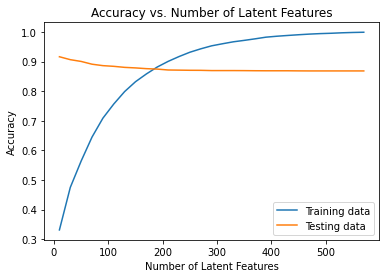

In [55]:
plt.plot(num_latent_feats, 1 - (sum_train_errs/df_train.shape[0]) , label = 'Training data');
plt.plot(num_latent_feats, 1 - (sum_test_errs/df_test.shape[0])  , label = 'Testing data' );
plt.xlabel('Number of Latent Features');
plt.legend();
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The accuracy for the prediction for the training data goes up with the number of latent features (as expected from our previous graph in `3.`) However, the accuracy for the testing data *falls* as the number of latent features goes up. We note that there are only 20 users in common between the training and testing set; as the number of latent features increases, the model is becoming overfitted on the training data so it becomes worse at fitting the testing data.**

**To determine if the recommendations made with any of the above recommendation systems are an improvement, we could perform an A/B test. No change would be made to the website for the control group. The experimental group are shown articles based on the recommendation systems developed above. At the end of the study, if our recommendation system(s) are an improvement over the status quo we expect there to be more user-article interactions in the experimental group.**

<a id='conclusions'></a>

## Create html version of this notebook

In [56]:
# https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-jupyter-notebook-name

In [57]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [58]:
#print(theNotebook)

In [59]:
# If this cell works correctly, a return code of 0 is displayed
import os
os.system('jupyter nbconvert --to html Recommendations_with_IBM.ipynb')

0